In [5]:
%matplotlib inline
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%load_ext autoreload
%autoreload 2
from helpers import *
from numba import jit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
path_dataset = "data_train.csv"
ratings0 = load_data(path_dataset)
print('Shape of ratings matrix:',ratings.shape)

number of items: 10000, number of users: 1000
Shape of ratings matrix: (100, 100)


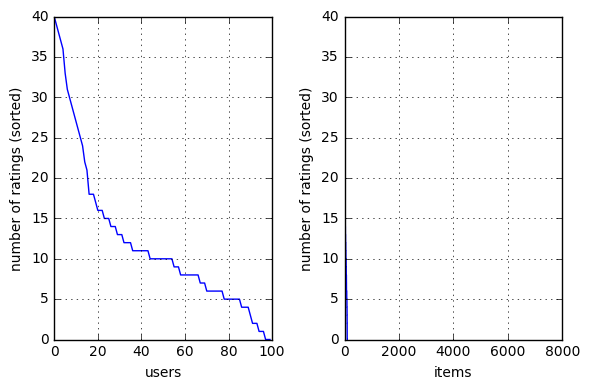

min # of items per user = 0, min # of users per item = 0.


In [7]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

In [8]:
# Let's first play with a submatrix
ratings = ratings0[:100,:100]
print('No of non-zero elements in ratings submatrix:',len(ratings.nonzero()[0]))

No of non-zero elements in ratings submatrix: 1213


In [16]:
ratings = ratings0

In [17]:
def init_MF_random(train, num_features):
    """init the parameter for matrix factorization."""
    
    #     to be returned:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    
    
    item_features = np.random.random((train.shape[0],num_features))  # W matrix initialization
    user_features = np.random.random((train.shape[1],num_features)) # Z matrix initialization
    
    return user_features, item_features

In [18]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    #     to be returned:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    
    train_svd = np.zeros(train.shape)
    for i in range(train.shape[0]):
        for j in range(train.shape[1]):
            train_svd[i,j] = train[i,j]
    
    U, s, V = np.linalg.svd(train_svd, full_matrices=False)
    
    S = np.diag(s)

    U_1 = U[:,0:num_features]
    S_1 = S[0:num_features, 0:num_features]
    V_1 = V[0:num_features, :]
    
    item_features = U_1 # W matrix of the decomposition
    user_features = (S_1.dot(V_1) ).T # Z matrix of the decomposition
    
    
    #raise NotImplementedError
    
    return user_features, item_features

In [56]:
# define parameters
gamma = 0.000020
num_features = 50   # K in the lecture notes
lambda_user = 0.0
lambda_item = 0.0
num_epochs = 50     # number of full passes through the train set
errors = [0]

# set seed
np.random.seed(988)

train = ratings

# init matrix
user_features, item_features = init_MF_random(train, num_features)

# find the non-zero ratings indices 
nz_row, nz_col = train.nonzero()
nz_train = list(zip(nz_row, nz_col))

In [57]:
@jit
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

In [58]:
real_train_label = np.zeros(len(nz_train))
prediction_train = np.zeros(len(nz_train))
rmse_train = np.zeros(num_epochs)

for it in range(num_epochs): 
    
    print('Iteration sankhya',it,'haazir hoooooo!!!')
    # shuffle the training rating indices
    np.random.shuffle(nz_train)

    # decrease step size
    # gamma /= 1.2
    count = 0
    mat_pred = np.dot(item_features,user_features.T)
    begin = datetime.datetime.now()
    print('beginning step 1')
    count = 0
    for d,n in nz_train:
        
        if count%100000 == 0:
            print(count)
            
        difference = train[d,n] - mat_pred[d,n]
        
        # Updating the W
        
        gradient1 = -1* (difference) * user_features[n,:]
        item_features[d,:] = item_features[d,:] - gamma * gradient1
        

        # Updating the Z
        
        gradient2 = -1* (difference) * item_features[d,:]
        user_features[n,:] = user_features[n,:] - gamma * gradient2
        
        count += 1
            
    mat_pred = np.dot(item_features,user_features.T)
    print('beginning step 2')
    
    #Calculating training rmse
    for i in range(len(nz_train)):
        real_train_label[i] = train[nz_train[i][0],nz_train[i][1]]
        prediction_train[i] = mat_pred[nz_train[i][0],nz_train[i][1]]
        
    
    
    rmse_train[it] = calculate_mse(real_train_label, prediction_train) 
    
    rmse = rmse_train[it]
    
    print("iter: {}, RMSE on training set: {}.".format(it, rmse))
    end = datetime.datetime.now()
    execution_time = (end - begin).total_seconds()
    print(execution_time)

Iteration sankhya 0 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
beginning step 2
iter: 0, RMSE on training set: 5.165188967688704.
33.927478
Iteration sankhya 1 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
beginning step 2
iter: 1, RMSE on training set: 3.8883215787866923.
32.364387
Iteration sankhya 2 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
beginning step 2
iter: 2, RMSE on training set: 3.1857147215299357.
32.141906
Iteration sankhya 3 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
beginning step 2
iter: 3, RMSE on training set: 2.7356951093525677.
31.491069
Iteration sankhya 4 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
beginning

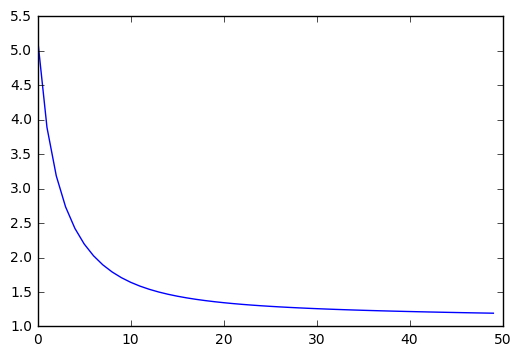

In [59]:
plt.plot(rmse_train)

In [71]:
real_train_label = np.zeros(len(nz_train))
prediction_train = np.zeros(len(nz_train))
rmse_train_new = np.zeros(num_epochs)

for it in range(50,150): 
    
    print('Iteration sankhya',it,'haazir hoooooo!!!')
    # shuffle the training rating indices
    np.random.shuffle(nz_train)

    # decrease step size
    # gamma /= 1.2
    count = 0
    mat_pred = np.dot(item_features,user_features.T)
    begin = datetime.datetime.now()
    print('beginning step 1')
    count = 0
    for d,n in nz_train:
        
        if count%100000 == 0:
            print(count)
            
        difference = train[d,n] - mat_pred[d,n]
        
        # Updating the W
        
        gradient1 = -1* (difference) * user_features[n,:]
        item_features[d,:] = item_features[d,:] - gamma * gradient1
        

        # Updating the Z
        
        gradient2 = -1* (difference) * item_features[d,:]
        user_features[n,:] = user_features[n,:] - gamma * gradient2
        
        count += 1
            
    mat_pred = np.dot(item_features,user_features.T)
    print('beginning step 2')
    
    #Calculating training rmse
    for i in range(len(nz_train)):
        real_train_label[i] = train[nz_train[i][0],nz_train[i][1]]
        prediction_train[i] = mat_pred[nz_train[i][0],nz_train[i][1]]
        
    
    
    rmse_train_new[it-50] = calculate_mse(real_train_label, prediction_train) 
    
    rmse = rmse_train_new[it-50]
    
    print("iter: {}, RMSE on training set: {}.".format(it, rmse))
    end = datetime.datetime.now()
    execution_time = (end - begin).total_seconds()
    print(execution_time)

Iteration sankhya 50 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
beginning step 2
iter: 50, RMSE on training set: 1.187800924086863.
48.863731
Iteration sankhya 51 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
beginning step 2
iter: 51, RMSE on training set: 1.1856765252899548.
42.841945
Iteration sankhya 52 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
beginning step 2
iter: 52, RMSE on training set: 1.1836097499983744.
40.942748
Iteration sankhya 53 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
beginning step 2
iter: 53, RMSE on training set: 1.181597207789748.
46.371552
Iteration sankhya 54 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
b

IndexError: index 50 is out of bounds for axis 0 with size 50

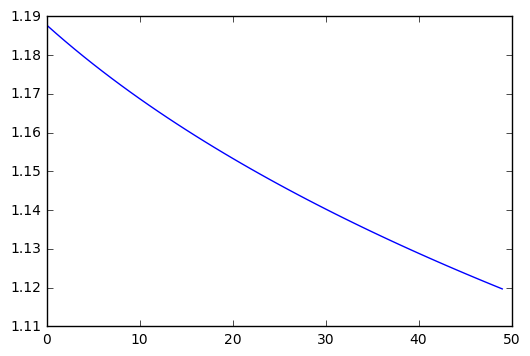

In [73]:
plt.plot(rmse_train_new)

In [74]:
it

100

In [76]:
real_train_label = np.zeros(len(nz_train))
prediction_train = np.zeros(len(nz_train))
rmse_train_new1 = np.zeros(num_epochs)

for it in range(100,150): 
    
    print('Iteration sankhya',it,'haazir hoooooo!!!')
    # shuffle the training rating indices
    np.random.shuffle(nz_train)

    # decrease step size
    # gamma /= 1.2
    count = 0
    mat_pred = np.dot(item_features,user_features.T)
    begin = datetime.datetime.now()
    print('beginning step 1')
    count = 0
    for d,n in nz_train:
        
        if count%100000 == 0:
            print(count)
            
        difference = train[d,n] - mat_pred[d,n]
        
        # Updating the W
        
        gradient1 = -1* (difference) * user_features[n,:]
        item_features[d,:] = item_features[d,:] - gamma * gradient1
        

        # Updating the Z
        
        gradient2 = -1* (difference) * item_features[d,:]
        user_features[n,:] = user_features[n,:] - gamma * gradient2
        
        count += 1
            
    mat_pred = np.dot(item_features,user_features.T)
    print('beginning step 2')
    
    #Calculating training rmse
    for i in range(len(nz_train)):
        real_train_label[i] = train[nz_train[i][0],nz_train[i][1]]
        prediction_train[i] = mat_pred[nz_train[i][0],nz_train[i][1]]
        
    
    
    rmse_train_new1[it-100] = calculate_mse(real_train_label, prediction_train) 
    
    rmse = rmse_train_new1[it-100]
    
    print("iter: {}, RMSE on training set: {}.".format(it, rmse))
    end = datetime.datetime.now()
    execution_time = (end - begin).total_seconds()
    print(execution_time)

Iteration sankhya 100 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
beginning step 2
iter: 100, RMSE on training set: 1.1168166569583688.
44.214046
Iteration sankhya 101 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
beginning step 2
iter: 101, RMSE on training set: 1.1158795481829085.
54.45631
Iteration sankhya 102 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
beginning step 2
iter: 102, RMSE on training set: 1.1149519850141547.
38.124038
Iteration sankhya 103 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
beginning step 2
iter: 103, RMSE on training set: 1.1140338378391683.
47.571343
Iteration sankhya 104 haazir hoooooo!!!
beginning step 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000

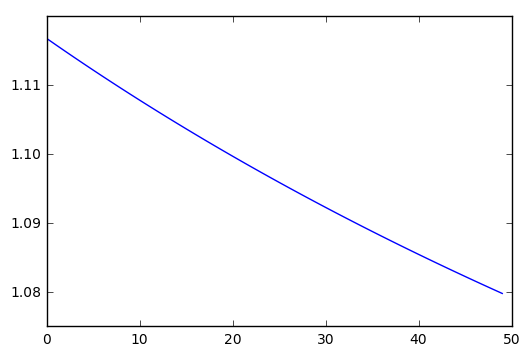

In [77]:
plt.plot(rmse_train_new1)

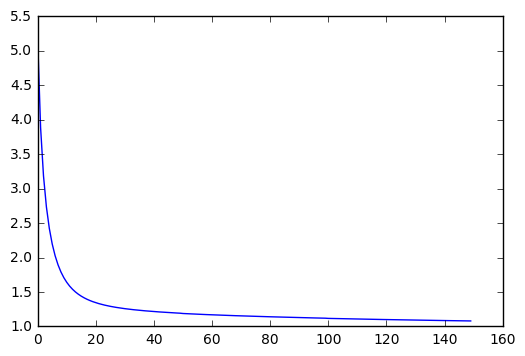

In [90]:
plt.plot(np.concatenate((rmse_train,rmse_train_new, rmse_train_new1),axis=0))
